# DA-DAN Modulation Analysis Project

### Set-Up

In [171]:
### imports
import navis
import fafbseg
import flybrains

import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from functools import reduce
from tabulate import tabulate
import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.gridspec as gridspec
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Title

import pyroglancer
from pyroglancer.localserver import startdataserver, closedataserver
from pyroglancer.flywire import flywireurl2dict, add_flywirelayer, set_flywireviewerstate

import navis.interfaces.neuprint as neu
from navis.interfaces.neuprint import NeuronCriteria as NC, SynapseCriteria as SC
from navis.interfaces.neuprint import fetch_adjacencies, fetch_synapse_connections

from pyroglancer.layers import create_nglayer, setlayerproperty
from pyroglancer.ngviewer import openviewer, closeviewer,setviewerstate, get_ngscreenshot
from pyroglancer.ngspaces import create_ngspace
from pyroglancer.createconfig import createconfig

from neuprint import fetch_synapses, NeuronCriteria as NC, SynapseCriteria as SC


import re

import utils
from utils import getFilteredConnections, extractAxonsPerType, extractDendritesPerType, plotPAMStatistic


In [90]:
import warnings
from pandas.errors import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [91]:
"""
label_fontsize = 16 
title_fontsize = 18

figwidth_size = 5
figheigth_size = 5

#navis display options for frontal view..
elev = -180
azim = -90
dist = 6
"""

'\nlabel_fontsize = 16 \ntitle_fontsize = 18\n\nfigwidth_size = 5\nfigheigth_size = 5\n\n#navis display options for frontal view..\nelev = -180\nazim = -90\ndist = 6\n'

In [92]:
print('navis version :',navis.__version__)
print('fafbseg version :',fafbseg.__version__)
print('flybrains version :',flybrains.__version__)
print('pyroglancer version :',pyroglancer.__version__)


navis version : 1.5.0
fafbseg version : 3.0.0
flybrains version : 0.2.9
pyroglancer version : 0.0.5


### Fetch data from Neuprint

In [93]:
## setting up Neuprint Client
## using dotenv to import Janelia PAT
from dotenv import load_dotenv
import os
load_dotenv()

## fetching Janelia client
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.2.1', token=os.environ.get("JANELIA_PAT"))
client

Client("https://neuprint.janelia.org", "hemibrain:v1.2.1")

In [94]:
### print roi hierarchy
rois = neu.fetch_roi_hierarchy(False,True,'text')
print(rois)

hemibrain
 +-- AL(L)*
 +-- AL(R)*
 +-- AOT(R)
 +-- CX
 |   +-- AB(L)*
 |   +-- AB(R)*
 |   +-- EB*
 |   +-- FB*
 |   +-- NO*
 |   +-- PB*
 +-- GC
 +-- GF(R)
 +-- GNG*
 +-- INP
 |   +-- ATL(L)*
 |   +-- ATL(R)*
 |   +-- CRE(L)*
 |   +-- CRE(R)*
 |   +-- IB*
 |   +-- ICL(L)*
 |   +-- ICL(R)*
 |   +-- SCL(L)*
 |   +-- SCL(R)*
 +-- LH(R)*
 +-- LX(L)
 |   +-- BU(L)*
 |   +-- LAL(L)*
 +-- LX(R)
 |   +-- BU(R)*
 |   +-- LAL(R)*
 +-- MB(+ACA)(R)
 |   +-- MB(R)
 |   |   +-- CA(R)*
 |   |   +-- PED(R)*
 |   |   +-- a'L(R)*
 |   |   +-- aL(R)*
 |   |   +-- b'L(R)*
 |   |   +-- bL(R)*
 |   |   +-- gL(R)*
 |   +-- dACA(R)
 |   +-- lACA(R)
 |   +-- vACA(R)
 +-- MB(L)
 |   +-- CA(L)*
 |   +-- a'L(L)*
 |   +-- aL(L)*
 |   +-- b'L(L)*
 |   +-- bL(L)*
 |   +-- gL(L)*
 +-- OL(R)
 |   +-- AME(R)*
 |   +-- LO(R)*
 |   +-- LOP(R)*
 |   +-- ME(R)*
 +-- PENP
 |   +-- CAN(R)*
 |   +-- FLA(R)*
 |   +-- PRW*
 |   +-- SAD*
 +-- POC
 +-- SNP(L)
 |   +-- SIP(L)*
 |   +-- SMP(L)*
 +-- SNP(R)
 |   +-- SIP(R)*
 |   +-

## Analysis

#### Get PAM neurons from hemibrains and fetch their connections

In [95]:
## fetch all neurons containing "PAM" from hemibrain dataset
pamneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type="^PAM.*",regex=True)) 

In [96]:
### print unique PAM types
uniquePAMTypes = pamneurons_df.type.unique()
print(uniquePAMTypes)

['PAM09' 'PAM10' 'PAM04_a' 'PAM04_b' 'PAM01_b' 'PAM11' 'PAM01_a' 'PAM05'
 'PAM08_c' 'PAM08_e' 'PAM02' 'PAM06_b' 'PAM14' 'PAM13' 'PAM06_a' 'PAM08_b'
 'PAM12' 'PAM03' 'PAM08_a' 'PAM07' 'PAM08_d' 'PAM15_a' 'PAM15_b']


In [97]:
### get PAM-PAM connections
filteredConnections = getFilteredConnections(silent=False)

  0%|          | 0/2 [00:00<?, ?it/s]

         bodyId     type          instance
0     268725517    PAM09    PAM09(B1ped)_L
1     298595394    PAM10       PAM10(B1)_R
2     299613480    PAM09    PAM09(B1ped)_R
3     328253133    PAM10       PAM10(B1)_R
4     328546871    PAM10       PAM10(B1)_R
..          ...      ...               ...
296  5813100896    PAM12       PAM12(y3)_R
297  5813109941    PAM07  PAM07(y4<y1y2)_R
298  5813124740    PAM07  PAM07(y4<y1y2)_L
299  5813127030  PAM06_a   PAM06_a(B'2m)_R
300  5901205545    PAM05     PAM05(B'2p)_L

[301 rows x 3 columns]
      bodyId_pre  bodyId_post     roi  weight type_pre    instance_pre  \
0      268725517    298595394   bL(R)       2    PAM09  PAM09(B1ped)_L   
1      268725517    298595394  b'L(R)       1    PAM09  PAM09(B1ped)_L   
2      268725517    298595394   bL(L)       1    PAM09  PAM09(B1ped)_L   
3      268725517    299613480   bL(R)       1    PAM09  PAM09(B1ped)_L   
4      268725517    328253133   bL(L)       1    PAM09  PAM09(B1ped)_L   
...          ...

In [98]:
### extract unique neuron instances from PAM PAM connections and prepare for dict
uniquePAMNeuronsPre = filteredConnections["instance_pre"].unique()
print(uniquePAMNeuronsPre)
uniquePAMNeuronsPost = filteredConnections["instance_post"].unique()
print("")
print(uniquePAMNeuronsPost)

# Parse the unique values into a string for a dict
possibleTargetsInstance = "{" + ",\n".join(f"'{neuron}': '{neuron}'" for neuron in sorted(set(uniquePAMNeuronsPre).union(uniquePAMNeuronsPost))) + "}"
print("\nPossible Targets Instance for dict:")
print(possibleTargetsInstance)


["PAM13(B'1ap)_L" 'PAM07(y4<y1y2)_L' 'PAM10(B1)_L' 'PAM08_c(y4)_L'
 'PAM10(B1)_R' 'PAM04_a(B2)_R' "PAM13(B'1ap)_R" "PAM06_b(B'2m)_L"
 'PAM11(a1)_R' 'PAM11(a1)_L' "PAM06_a(B'2m)_L" 'PAM08_b(y4)_L'
 'PAM04_a(B2)_L' "PAM05(B'2p)_R" 'PAM08_c(y4)_R' "PAM05(B'2p)_L"
 "PAM06_a(B'2m)_R" "PAM14(B'1m)_R" 'PAM09(B1ped)_R' 'PAM09(B1ped)_L'
 'PAM12(y3)_L' "PAM02(B'2a)_R" 'PAM08_a(y4)_L' 'PAM01_b(y5)_R'
 'PAM07(y4<y1y2)_R' 'PAM01_b(y5)_L' 'PAM08_d(y4)_R' 'PAM08_d(y4)_L'
 'PAM01_a(y5)_R' "PAM14(B'1m)_L" "PAM15_b(y5B'2a)_R" 'PAM08_e(y4)_R'
 'PAM08_e(y4)_L' "PAM02(B'2a)_L" "PAM06_b(B'2m)_R" 'PAM04_b(B2)(ADM02)_L'
 'PAM12(y3)_R' "PAM03(B2B'2a)_R" 'PAM08_b(y4)_R' 'PAM08_a(y4)_R'
 "PAM03(B2B'2a)_L" 'PAM01_a(y5)_L' "PAM15_a(y5B'2a)_R" "PAM15_b(y5B'2a)_L"
 "PAM15_a(y5B'2a)_L" 'PAM04_b(B2)_R']

["PAM13(B'1ap)_L" 'PAM08_c(y4)_L' 'PAM10(B1)_L' "PAM13(B'1ap)_R"
 'PAM07(y4<y1y2)_L' 'PAM04_a(B2)_L' 'PAM08_a(y4)_L' 'PAM10(B1)_R'
 'PAM09(B1ped)_R' "PAM06_b(B'2m)_L" 'PAM08_b(y4)_L' 'PAM11(a1)_R'
 "PAM06_a(B'2m)_L" "

#### Heatmap Visualization of PAM-PAM connections

In [99]:
PAMSuperTypeCollapsedConnections = filteredConnections.replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM', regex=True)

#### visualize as matrix
matrix = neu.connection_table_to_matrix(PAMSuperTypeCollapsedConnections, 'type', sort_by='type',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

title="PAM-PAM Connections Heatmap"
matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title=title).opts(xrotation=60)


:HeatMap   [columns,index]   (value)

In [100]:
#### visualize as matrix
matrix = neu.connection_table_to_matrix(filteredConnections, 'type', sort_by='type',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

title="PAM-PAM Connections Heatmap"
matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title=title).opts(xrotation=60)


:HeatMap   [columns,index]   (value)

In [101]:
### collapse PAM types and then show as matrix

PAMCollapsedConnections = filteredConnections.replace(to_replace=r'PAM(\d{2})\_?\w?', value=r'PAM\1', regex=True)

matrix = neu.connection_table_to_matrix(PAMCollapsedConnections, 'type', sort_by='type',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title = title+" -- PAM Types Collapsed").opts(xrotation=60)

:HeatMap   [columns,index]   (value)

In [102]:
### show unique neurons as matrix
matrix = neu.connection_table_to_matrix(filteredConnections, 'instance', sort_by='instance',)
    ### note: this originally threw an error bc of deprecated call to df.pivot(), fixed it by updating the pivot call in neuprint/utils.py to:
    ### matrix = agg_weights_df.pivot(index=col_pre, columns=col_post, values=weight_col)

matrix.index = matrix.index.astype(str)
matrix.columns = matrix.columns.astype(str)

title="PAM-PAM Connections Heatmap"
matrix.hvplot.heatmap(height=600, width=700, xaxis='top', title=title+" -- PAM neurons").opts(xrotation=60)


:HeatMap   [columns,index]   (value)

#### detailed connection analysis

Prints out unique pre- and postsynaptic connection partners (grouped by supertype, type, subtype, instance, and bodyID) of a specific PAM type or all PAMs.

In [103]:
print("Printing unique connection partners of PAM04 neurons")
subTypePartners, instancePartners, bodyIdPartners = utils.listUniqueConnectionPartners(extractDendritesPerType("PAM04",connections=filteredConnections))

Printing unique connection partners of PAM04 neurons
Unique connection partners
by superType
['PAM']
by type
['PAM04' 'PAM11' 'PAM03' 'PAM10' 'PAM09' 'PAM06' 'PAM02' 'PAM01' 'PAM15'
 'PAM14' 'PAM13' 'PAM08' 'PAM05' 'PAM12']
by subType
['PAM04_a' 'PAM11' 'PAM03' 'PAM10' 'PAM09' 'PAM06_b' 'PAM04_b' 'PAM02'
 'PAM01_a' 'PAM15_a' 'PAM01_b' 'PAM06_a' 'PAM15_b' 'PAM14' 'PAM13'
 'PAM08_d' 'PAM08_b' 'PAM05' 'PAM12']
by instance
['PAM04_a(B2)_R' 'PAM04_a(B2)_L' 'PAM11(a1)_L' "PAM03(B2B'2a)_R"
 'PAM10(B1)_R' 'PAM09(B1ped)_R' 'PAM09(B1ped)_L' "PAM03(B2B'2a)_L"
 "PAM06_b(B'2m)_L" 'PAM04_b(B2)(ADM02)_L' "PAM02(B'2a)_L" 'PAM11(a1)_R'
 'PAM01_a(y5)_R' 'PAM10(B1)_L' "PAM02(B'2a)_R" "PAM15_a(y5B'2a)_L"
 'PAM01_b(y5)_L' "PAM06_a(B'2m)_R" 'PAM01_a(y5)_L' 'PAM04_b(B2)_R'
 "PAM15_b(y5B'2a)_R" "PAM06_b(B'2m)_R" "PAM14(B'1m)_L" "PAM14(B'1m)_R"
 "PAM13(B'1ap)_R" "PAM06_a(B'2m)_L" "PAM13(B'1ap)_L" 'PAM08_d(y4)_R'
 'PAM08_b(y4)_L' "PAM05(B'2p)_R" 'PAM12(y3)_L']
by bodyId
[1140996390  676612729 1047183897 1203066

In [104]:
### retrieving all connections between PAM neurons and any neurons
filteredPAMConnections = getFilteredConnections("^PAM.*","^.*", minWeight=1, bidirectional=True)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fifth percentile threshold value for connection weights: 1.0


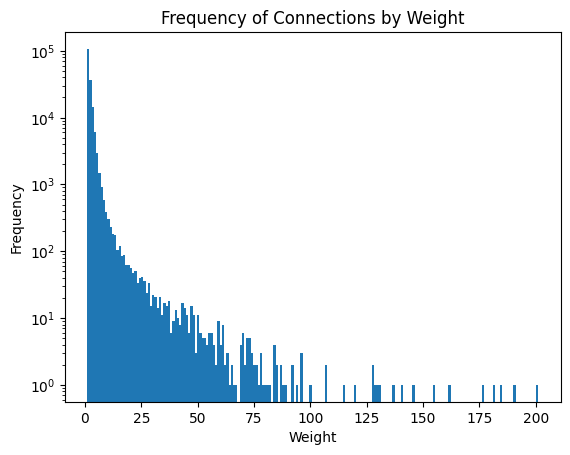

In [105]:
filteredPAMConnections['weight'].plot(kind='hist', bins=201, title='Frequency of Connections by Weight', logy=True)
# Calculate the fifth percentile threshold value for the 'weight' column
fifth_percentile_threshold = filteredPAMConnections['weight'].quantile(0.05)
print(f"Fifth percentile threshold value for connection weights: {fifth_percentile_threshold}")

plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()


In [106]:
print("Printing out unique connection partners of all PAMs")
print("\n Presynaptic")
typePartners, instancePartners, bodyIdPartners = utils.listUniqueConnectionPartners(filteredPAMConnections,type="pre")
print("\n Postsynaptic")
typePartners, instancePartners, bodyIdPartners = utils.listUniqueConnectionPartners(filteredPAMConnections,type="post")

Printing out unique connection partners of all PAMs

 Presynaptic
Unique connection partners
by superType
['PAM']
by type
['PAM10' 'PAM07' 'PAM11' ... 'SMP582' 'SLP417' 'SLP022']
by subType
['PAM10' 'PAM07' 'PAM11' ... 'SMP582' 'SLP417' 'SLP022']
by instance
['PAM10(B1)_R' 'PAM10(B1)_L' 'PAM07(y4<y1y2)_L' ... 'SMP582_R' 'SLP417_R'
 'SLP022_R']
by bodyId
[455431209 328546871 359598627 ... 327873821 327872592 327861138]

 Postsynaptic
Unique connection partners
by superType
['PAM']
by type
['MBON06' 'MBON05' 'MBON07' 'MBON03' 'MBON04' 'MBON26' 'APL' 'MBON01'
 'MBON21' 'MBON24' 'MBON02' 'MBON29' 'DPM' 'PAM02' 'PAM07' 'PAM01'
 'MBON09' 'PAM08' 'PAM12' 'PAM06' 'PAM10' 'PAM11' 'PAM13' 'PAM15' 'MBON27'
 'PAM14' 'PAM05' 'PAM09' 'MBON33' 'PAM04' 'PAM03' 'KCab-p' 'MBON10'
 'CRE011' 'MBON30' 'KCg-s1' 'PPL101' 'MBON11' "KCa'b'-ap1" 'KCg-s3'
 'SMP376' "KCa'b'-m" 'SMP108' 'CRE048' 'KCg-d' 'CRE024' 'KCg-s2'
 "KCa'b'-ap2" 'PPL104' 'CRE067' 'LAL159' 'KCg-m' 'SMP031' 'SMP156'
 'KCg-s4' 'KCab-s' 'CRE080'

In [107]:
##testing whether connections make sense
extractDendritesPerType(target="PAM05",connections=filteredPAMConnections)
extractAxonsPerType(target="PAM05",connections=filteredPAMConnections)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
69087,5813069965,487925063,b'L(L),77,PAM05,PAM05(B'2p)_L,MBON04,MBON04(B'2mp_bilateral)_R
8114,549610772,895441451,b'L(R),75,PAM05,PAM05(B'2p)_R,MBON26,MBON26(B'2d)_R
64514,5812983399,912951014,b'L(L),74,PAM05,PAM05(B'2p)_L,MBON26,MBON26(B'2d)(PDM28)_L
69138,5813069965,912951014,b'L(L),70,PAM05,PAM05(B'2p)_L,MBON26,MBON26(B'2d)(PDM28)_L
45788,1171690479,895441451,b'L(R),66,PAM05,PAM05(B'2p)_R,MBON26,MBON26(B'2d)_R
...,...,...,...,...,...,...,...,...
67755,5813047784,1131826900,b'L(L),1,PAM05,PAM05(B'2p)_L,FB4O,FB4O_L
67754,5813047784,1111947403,b'L(R),1,PAM05,PAM05(B'2p)_L,KCa'b'-ap1,KCa'b'-ap1_R
67753,5813047784,1081767446,b'L(L),1,PAM05,PAM05(B'2p)_L,PAM05,PAM05(B'2p)_L
67752,5813047784,1081434698,CRE(L),1,PAM05,PAM05(B'2p)_L,PAM07,PAM07(y4<y1y2)_L


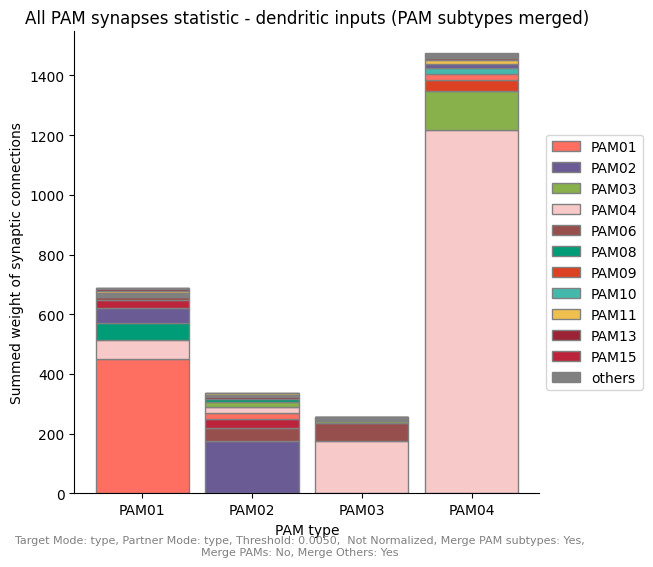

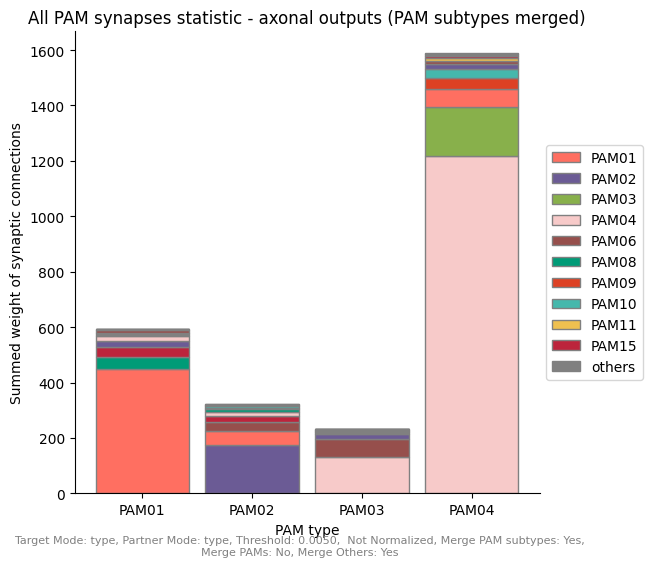

In [108]:
### 
targets = ["PAM01","PAM02","PAM03","PAM04"]
partnerType = "type" ## instance, type, bodyId
#connections = filteredPAMConnections
connections = filteredConnections
treshhold= 0.005
plotPAMStatistic(connections=connections,targets=targets,etcTreshhold=treshhold,partnerMode=partnerType,normalized=False, mergePAMSubtypes = True, title="All PAM synapses statistic", mergePAMsupertype=  False, weightFilterThreshhold=1)

In [109]:
### 
targets = ["PAM01_a(y5)_L"]
partnerType = "type" ## instance, type, bodyId

treshhold= 0.02
#plotPAMStatistic(connections=filteredPAMConnections,targets=targets,targetMode="instance",etcTreshhold=treshhold,partnerMode=partnerType,normalized=False, mergePAMSubtypes = False, title="All PAM synapses statistic", mergePAMs = False)



#### Visualization of PAM-PAM synapses

In [110]:
# RETRIEVE ALL PAM-PAM SYNAPSES

## get PAM neurons 
neuron_criteria = NC(status='Traced', type="^PAM.*",regex=True)

## get all synapses, within and outside MB
allPAMPAMpresynapses_criteria = SC(type='pre', primary_only=True)
allPAMPAMpostsynapses_criteria = SC(type='post', primary_only=True)
allPAMPAMpresynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, allPAMPAMpresynapses_criteria,batch_size=10000)
allPAMPAMpostsynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, allPAMPAMpostsynapses_criteria,batch_size=10000)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10509 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10509 [00:00<?, ?it/s]

The fifth percentile of the 'confidence_pre' values is: 0.800000011920929


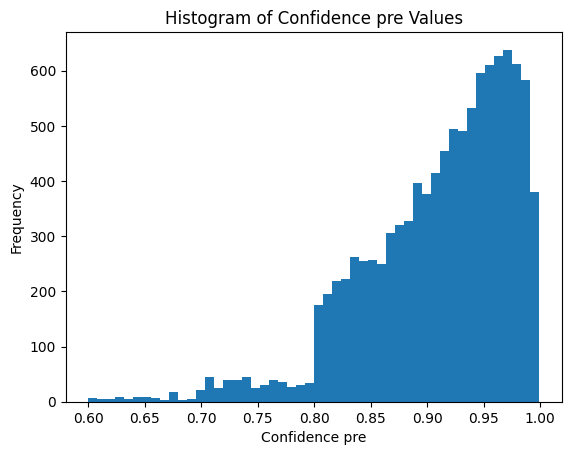

The fifth percentile of the 'confidence_post' values is: 0.37769100069999695


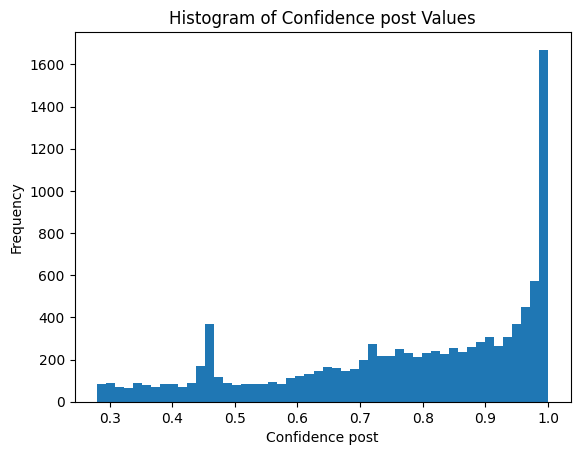

0.37769100069999695

In [111]:
def plotSynapseConfidence(synapseTable, mode="pre", show=True):
    # Plotting histogram of frequency of each value in column 'confidence_pre'
    plt.hist(synapseTable['confidence_'+mode], bins=50)
    fifth_percentile = np.percentile(synapseTable['confidence_'+mode], 5)
    print("The fifth percentile of the 'confidence_"+mode+"' values is:", fifth_percentile)

    plt.xlabel('Confidence '+mode)
    plt.ylabel('Frequency')
    plt.title('Histogram of Confidence '+mode+' Values')
    plt.show()
    return fifth_percentile

def filterSynapseConfidence(synapseTable, mode="pre", percentile = 5):
    perc = np.percentile(synapseTable['confidence_'+mode], percentile)
    synapseTable = synapseTable[synapseTable['confidence_'+mode] > perc]
    return synapseTable


plotSynapseConfidence(allPAMPAMpresynapses, mode="pre")
plotSynapseConfidence(allPAMPAMpostsynapses, mode="post")

In [112]:
PAMPAMpresynapses = filterSynapseConfidence(allPAMPAMpresynapses,mode="pre")
PAMPAMpostsynapses = filterSynapseConfidence(allPAMPAMpostsynapses,mode="post")

In [113]:
#fetch mesh for mushroombody..
mb_mesh = neu.fetch_roi('MB')
mb_mesh.color = (.9, .9, .9, .75) #,(.9, .9, .9, .05)


# Generate 2D outlines for roi
def get_outlines(roi, view = 'xz'):
    roi2d = np.array(roi.to_2d(alpha = 2,view = view))
    roi_outlines = np.append(roi2d, np.repeat(roi.center[2], roi2d.shape[0]).reshape(roi2d.shape[0], 1), axis=1)
    return roi_outlines

#mb_outlines = get_outlines(mb_mesh)



In [174]:
def plotSynapseGroups(synapseTables=[PAMPAMpresynapses, PAMPAMpostsynapses], title = "Synapse Plot",colors = ["red","blue","green", "yellow"], coordinates=["x","z"], showPlot = True):
    p = figure(title=title)
    i = 0
    for synapses in synapseTables:
        p.scatter(synapses[coordinates[0]+'_post'], synapses[coordinates[1]+'_post'], color=colors[i])
        i = i+1
    p.y_range.flipped = True
    if showPlot:
        show(p)

def plotSynapseClassification(synapseTable, title = "Synapse Classification", classificationColumn = "classification", classificationInterval=[0,1,2,3,4],  colors = ["grey","red","blue","green", "cyan"], labels=["Heterogenous","Same Supertype","Same Type","Same Instance","Same Body ID"], coordinates=["x","z"], showPlot = True, subtitle=None):
    p = figure(title=title)
    i = 0
    for classification in classificationInterval:
        synapses = synapseTable[(synapseTable[classificationColumn]==classification)]
        n = synapses.index.size
        p.scatter(synapses[coordinates[0]+'_post'], synapses[coordinates[1]+'_post'], color=colors[i], legend_label=labels[i]+", "+str(n))
        i += 1
    p.y_range.flipped = True
    if subtitle:
        p.add_layout(Title(text=subtitle, align="center"), "below")
    if showPlot:
        show(p)
    

In [115]:
title = "PAM-PAM synapses (red: pre, blue: post)"
plotSynapseGroups([PAMPAMpresynapses,PAMPAMpostsynapses],title)
plotSynapseGroups([PAMPAMpresynapses,PAMPAMpostsynapses],title, coordinates=["x","y"])

In [116]:
print("Printing ROIs with PAM-PAM presynapses")
print(sorted(filter(None, PAMPAMpresynapses["roi_pre"].unique())))
print(sorted(filter(None, PAMPAMpostsynapses["roi_pre"].unique())))
print("\nPrinting ROIs with PAM-PAM postsynapses")
print(sorted(filter(None, PAMPAMpresynapses["roi_post"].unique())))
print(sorted(filter(None, PAMPAMpostsynapses["roi_post"].unique())))


Printing ROIs with PAM-PAM presynapses
['CRE(L)', 'CRE(R)', 'EB', 'LAL(L)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']
['CRE(L)', 'CRE(R)', 'EB', 'LAL(L)', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']

Printing ROIs with PAM-PAM postsynapses
['CRE(L)', 'CRE(R)', 'EB', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']
['CRE(L)', 'CRE(R)', 'EB', 'PED(R)', 'SIP(L)', 'SIP(R)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']


In [117]:
noneRoiPresynapses = PAMPAMpresynapses[allPAMPAMpresynapses["roi_post"].isnull()]
noneRoiPostsynapses = PAMPAMpostsynapses[allPAMPAMpostsynapses["roi_post"].isnull()]

/var/folders/4d/7160z4vd1rg28c6kn6x471p80000gn/T/ipykernel_15761/1606454332.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  noneRoiPresynapses = PAMPAMpresynapses[allPAMPAMpresynapses["roi_post"].isnull()]
/var/folders/4d/7160z4vd1rg28c6kn6x471p80000gn/T/ipykernel_15761/1606454332.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  noneRoiPostsynapses = PAMPAMpostsynapses[allPAMPAMpostsynapses["roi_post"].isnull()]


### analyzing MB and non-MB synapses

In [118]:
## get PAM neurons 
neuron_criteria = NC(status='Traced', type="^PAM.*",regex=True)

In [119]:
## get synapses within MB
MB_rois=["a'L(R)","aL(R)","b'L(R)","bL(R)","gL(R)","CA(L)","a'L(L)","aL(L)","b'L(L)","bL(L)","gL(L)", "CA(R)", "PED(R)"]
MBpresynapses_criteria = SC(type='pre', primary_only=True,rois=MB_rois)
MBpostsynapses_criteria = SC(type='post', primary_only=True,rois=MB_rois)
allMBpresynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, MBpresynapses_criteria)
allMBpostsynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, MBpostsynapses_criteria)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9716 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9716 [00:00<?, ?it/s]

In [120]:
## get synapses outside MB
### previously, these ROIs have been found to be the ROIs outside the MB that have PAM-PAM connections
non_MB_rois=["CRE(L)", "CRE(R)", "EB", "LAL(R)", "SIP(L)", "SIP(R)", "SLP(R)", "SMP(L)", "SMP(R)", "LAL(L)"]
nonMBpresynapses_criteria = SC(type='pre', primary_only=True,rois=non_MB_rois)
nonMBpostsynapses_criteria = SC(type='post', primary_only=True,rois=non_MB_rois)
allNonMBpresynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, nonMBpresynapses_criteria)
allNonMBpostsynapses = fetch_synapse_connections(neuron_criteria, neuron_criteria, nonMBpostsynapses_criteria)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

In [121]:
MBpresynapses = filterSynapseConfidence(allMBpresynapses,mode="pre")
MBpostsynapses = filterSynapseConfidence(allMBpostsynapses,mode="post")
nonMBpresynapses = filterSynapseConfidence(allNonMBpresynapses,mode="pre")
nonMBpostsynapses = filterSynapseConfidence(allNonMBpostsynapses,mode="post")

In [122]:
print(MBpresynapses.index.size)
print(MBpostsynapses.index.size)
print(nonMBpresynapses.index.size)
print(nonMBpostsynapses.index.size)


9202
9230
561
562


##### Visualization of PAM-PAM synapses inside/outside MB

In [135]:
# Plot the synapse positions in a 2D projection
## blue synapses are MB synapses, red are outside the MB
title = "PAM-PAM synapses (red: MB, blue: non-MB, green: ROI 'None')"

plotSynapseGroups([MBpresynapses,nonMBpresynapses,noneRoiPresynapses],title)
plotSynapseGroups([MBpresynapses,nonMBpresynapses,noneRoiPresynapses],title, coordinates=["x","y"])

### analysis of synapse details

In [136]:
allPAMPAMpresynapses

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post
0,735282133,268725517,bL(L),bL(L),34285,31311,19613,34280,31294,19618,0.900,0.671950
1,735282133,268725517,bL(L),bL(L),33984,30918,19675,33983,30938,19689,0.888,0.479329
2,643535876,268725517,b'L(R),b'L(R),17457,31462,19102,17439,31453,19110,0.976,0.998155
3,643535876,268725517,b'L(R),b'L(R),17638,31333,19170,17616,31324,19173,0.984,0.379946
4,582148591,268725517,bL(L),bL(L),33925,32365,20704,33925,32396,20684,0.918,0.504105
...,...,...,...,...,...,...,...,...,...,...,...,...
10504,1169989859,5901205545,b'L(L),b'L(L),29476,27314,17042,29464,27329,17048,0.967,0.856749
10505,1141337557,5901205545,CRE(R),CRE(R),23028,28466,16511,23035,28481,16528,0.899,0.414287
10506,1139724251,5901205545,b'L(L),b'L(L),29683,27209,17034,29674,27193,17043,0.726,0.913667
10507,1081767446,5901205545,b'L(L),b'L(L),31121,29357,16942,31109,29335,16938,0.860,0.594837


In [125]:
all_neurons, roi_count = neu.fetch_neurons(NC(status='Traced',type="^.*",regex=True)) 

In [126]:
from utils import collapseNeuronNames, classify_connections

In [127]:
mergedPPpresynapses = neu.merge_neuron_properties(all_neurons,allPAMPAMpresynapses,properties=["type", "instance"])
mergedPPpostynapses = neu.merge_neuron_properties(all_neurons,allPAMPAMpostsynapses,properties=["type", "instance"])

In [128]:
mergedPPpresynapses

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post,type_pre,instance_pre,type_post,instance_post
0,735282133,268725517,bL(L),bL(L),34285,31311,19613,34280,31294,19618,0.900,0.671950,PAM09,PAM09(B1ped)_L,PAM09,PAM09(B1ped)_L
1,735282133,268725517,bL(L),bL(L),33984,30918,19675,33983,30938,19689,0.888,0.479329,PAM09,PAM09(B1ped)_L,PAM09,PAM09(B1ped)_L
2,643535876,268725517,b'L(R),b'L(R),17457,31462,19102,17439,31453,19110,0.976,0.998155,PAM10,PAM10(B1)_L,PAM09,PAM09(B1ped)_L
3,643535876,268725517,b'L(R),b'L(R),17638,31333,19170,17616,31324,19173,0.984,0.379946,PAM10,PAM10(B1)_L,PAM09,PAM09(B1ped)_L
4,582148591,268725517,bL(L),bL(L),33925,32365,20704,33925,32396,20684,0.918,0.504105,PAM10,PAM10(B1)_L,PAM09,PAM09(B1ped)_L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10504,1169989859,5901205545,b'L(L),b'L(L),29476,27314,17042,29464,27329,17048,0.967,0.856749,PAM05,PAM05(B'2p)_R,PAM05,PAM05(B'2p)_L
10505,1141337557,5901205545,CRE(R),CRE(R),23028,28466,16511,23035,28481,16528,0.899,0.414287,PAM08_d,PAM08_d(y4)_R,PAM05,PAM05(B'2p)_L
10506,1139724251,5901205545,b'L(L),b'L(L),29683,27209,17034,29674,27193,17043,0.726,0.913667,PAM06_a,PAM06_a(B'2m)_L,PAM05,PAM05(B'2p)_L
10507,1081767446,5901205545,b'L(L),b'L(L),31121,29357,16942,31109,29335,16938,0.860,0.594837,PAM05,PAM05(B'2p)_L,PAM05,PAM05(B'2p)_L


In [137]:
title = "PAM-PAM Synapse Types"
mergedPPpresynapses = classify_connections(mergedPPpresynapses)
mergedPPpostynapses = classify_connections(mergedPPpostynapses)
plotSynapseClassification(mergedPPpresynapses,title=title)
plotSynapseClassification(mergedPPpresynapses, title=title, coordinates=["x","y"])

In [130]:
## fetch all synapses that involve PAM,
## postsynapses are 1:1 identical to presynapses, both have n=150049 
pam_criteria = NC(status='Traced', type="^PAM.*",regex=True)
all_criteria = NC(status='Traced', type="^.*",regex=True)

allPAMpresynapses_criteria = SC(type='pre', primary_only=True)
#allPAMpostsynapses_criteria = SC(type='post', primary_only=True)
allPAMpresynapses = fetch_synapse_connections(pam_criteria, all_criteria, allPAMpresynapses_criteria,batch_size=10000)
#allPAMpostsynapses = fetch_synapse_connections(pam_criteria, all_criteria, allPAMpostsynapses_criteria,batch_size=10000)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/150049 [00:00<?, ?it/s]

In [147]:
PAMpresynapses = filterSynapseConfidence(allPAMpresynapses,mode="pre",percentile=10) 
mergedPAMpresynapses = neu.merge_neuron_properties(all_neurons,PAMpresynapses,properties=["type", "instance"])
#mergedPAMpostynapses = neu.merge_neuron_properties(all_neurons,allPAMpostsynapses,properties=["type", "instance"])

mergedPAMpresynapses = classify_connections(mergedPAMpresynapses)
#mergedPAMpostynapses = classify_connections(mergedPAMpostynapses)

In [148]:
title="PAM Presynapses Classification"
decimated_connections = mergedPAMpresynapses.sample(n=10000)
plotSynapseClassification(decimated_connections, title=title, coordinates=["x","z"])
plotSynapseClassification(decimated_connections, title=title, coordinates=["x","y"])


In [179]:
target = "PAM01"
def plotPAMTypePresynapses(pamType = "PAM01"):
    collapsedPAMpresynapses = collapseNeuronNames(mergedPAMpresynapses.copy(), [pamType], ["type"], sides=["pre", "post"], suffix="")
    filteredPAMpresynapses = collapsedPAMpresynapses[collapsedPAMpresynapses["type_pre"] == pamType].copy()
    filteredPAMpresynapses.drop(columns='classification', inplace=True)
    filteredPAMpresynapses = classify_connections(filteredPAMpresynapses)
    title=pamType+" Presynapses Classification"
    plotSynapseClassification(filteredPAMpresynapses,title=title,subtitle="Same Supertype: "+pamType+"-PAM, Same Type: "+pamType+"-"+pamType)
    plotSynapseClassification(filteredPAMpresynapses, title=title,coordinates=["x","y"])

In [182]:
plotPAMTypePresynapses("PAM03")